# Clustering

In [1]:
import pandas as pd

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import LabelEncoder


import matplotlib.pyplot as plt

import seaborn as sns

import math


In [2]:
#importing data

db = pd.read_csv('data/player_stats_injuries.csv')

db.head()

,PLAYER_ID,PLAYER_NAME,SEASON,SEASON_NUM,AGE,PLAYER_HEIGHT_INCHES,PLAYER_WEIGHT,GP,MIN,USG_PCT,...,AVG_SEC_PER_TOUCH,AVG_DRIB_PER_TOUCH,ELBOW_TOUCHES,POST_TOUCHES,PAINT_TOUCHES,TEAM,INJURED ON,RETURNED,DAYS MISSED,INJURED_TYPE
0,1630639,A.J. Lawson,22-23,22.5,22.0,78,179,13,4.8,0.182,...,1.39,0.62,0.0,0.0,0.2,NaN,NaN,NaN,NaN,NaN
1,1631260,AJ Green,22-23,22.5,23.0,77,190,32,9.4,0.160,...,2.61,1.84,0.1,0.0,0.3,NaN,NaN,NaN,NaN,NaN
2,1631100,AJ Griffin,22-23,22.5,19.0,78,220,66,19.4,0.174,...,2.08,1.49,0.4,0.0,0.7,NaN,NaN,NaN,NaN,NaN
3,203932,Aaron Gordon,22-23,22.5,27.0,80,235,61,30.1,0.206,...,2.94,2.11,1.8,2.1,6.8,Nuggets,2023-02-02,2023-02-07,5.0,Sprained_ankle
4,1628988,Aaron Holiday,22-23,22.5,26.0,72,185,57,13.7,0.128,...,4.17,3.82,0.1,0.0,0.4,NaN,NaN,NaN,NaN,NaN


In [3]:
# sns.set(style="whitegrid")

In [3]:
def evaluate_k_range(features, max_k=10):
    # Step 1: Extract and clean relevant columns
    data = db[features].copy()
    data = data.replace(['None', ' none', 'None ', ' none ', ' NONE', 'NONE', ' None'], pd.NA)

    # Step 2: Convert all to numeric (non-numeric strings become NaN)
    for col in data.columns:
        data[col] = pd.to_numeric(data[col], errors='coerce')

    # Step 3: Drop rows with missing values
    data = data.dropna()

    # Step 4: Scale the clean data
    scaler = StandardScaler()
    scaled = scaler.fit_transform(data)

    # Step 5: Evaluate WCSS and silhouette scores
    wcss = []
    silhouette_scores = []
    Ks = range(2, max_k + 1)

    for k in Ks:
        kmeans = KMeans(n_clusters=k, random_state=42)
        labels = kmeans.fit_predict(scaled)
        wcss.append(kmeans.inertia_)
        silhouette_scores.append(silhouette_score(scaled, labels))

    # Step 6: Plot Elbow & Silhouette
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(Ks, wcss, 'bo-')
    plt.xlabel('Number of Clusters (k)')
    plt.ylabel('WCSS (Inertia)')
    plt.title('Elbow Method for Optimal k')

    plt.subplot(1, 2, 2)
    plt.plot(Ks, silhouette_scores, 'go-')
    plt.xlabel('Number of Clusters (k)')
    plt.ylabel('Silhouette Score')
    plt.title('Silhouette Score for k')

    plt.tight_layout()
    plt.show()


In [4]:
def run_clustering(features, k=4, title="Clustering"):
  # Step 1: Extract relevant features
    data = db[features].copy()

    # Step 2: Replace string 'None', ' none', or similar with actual NaN
    data = data.replace(['None', ' none', 'None ', ' none ', ' NONE', 'NONE', ' None'], pd.NA)

    # Step 3: Convert all columns to numeric, coercing errors (invalid strings → NaN)
    for col in data.columns:
        data[col] = pd.to_numeric(data[col], errors='coerce')

    # Step 4: Drop rows with NaNs
    data = data.dropna()

    # Scale features
    scaler = StandardScaler()
    scaled = scaler.fit_transform(data)

    # K-Means clustering
    kmeans = KMeans(n_clusters=k, random_state=42)
    clusters = kmeans.fit_predict(scaled)

    # PCA for visualization
    pca = PCA(n_components=2)
    reduced = pca.fit_transform(scaled)

    # Plot
    plt.figure(figsize=(8, 6))
    sns.scatterplot(x=reduced[:, 0], y=reduced[:, 1], hue=clusters, palette="viridis")
    plt.title(title)
    plt.xlabel("PCA Component 1")
    plt.ylabel("PCA Component 2")
    plt.legend(title="Cluster")
    plt.show()

    # Return original data with cluster labels
    result = data.copy()
    result['Cluster'] = clusters
    return result

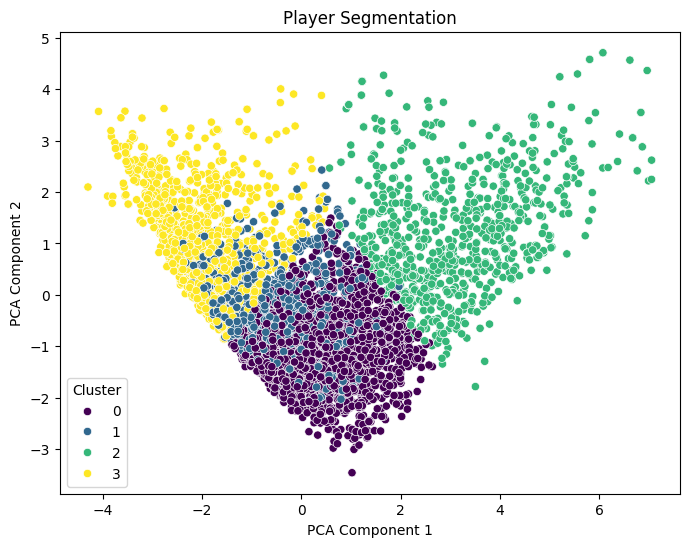

In [5]:
# 1. Player Segmentation: Based on physical attributes and playing style
segmentation_features = [
    'AGE', 'PLAYER_HEIGHT_INCHES', 'PLAYER_WEIGHT', 'DRIVES', 'DRIVE_FGA',
    'PULL_UP_FGA', 'PAINT_TOUCHES'
]
player_segments = run_clustering(segmentation_features, k=4, title="Player Segmentation")


In [17]:
db['INJURY_CODE'] = db['INJURED_TYPE'].replace(['None', ' none', 'NONE'], pd.NA)
db['INJURY_CODE'] = db['INJURY_CODE'].astype('category').cat.codes

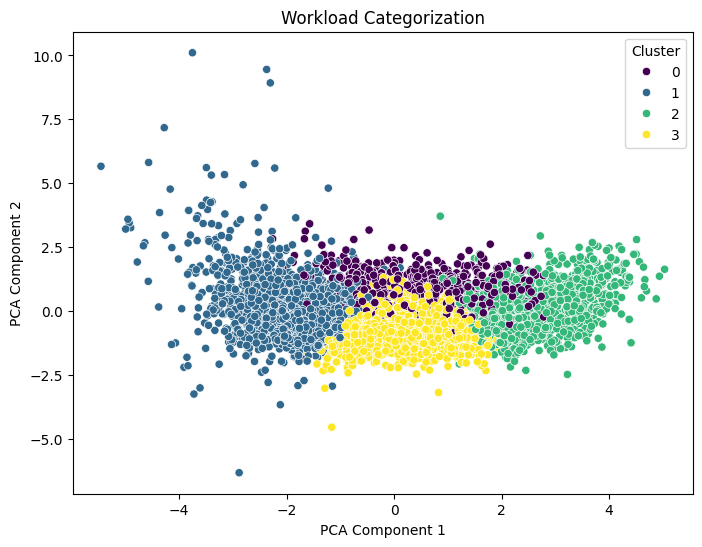

In [18]:
# 3. Workload Categorization: Based on intensity and minutes
workload_features = [
    'MIN', 'USG_PCT', 'FGA_PG', 'PACE', 'DIST_MILES', 'INJURY_CODE'
]
workload_clusters = run_clustering(workload_features, k=4, title="Workload Categorization")

In [19]:
# Re-add cluster labels to original dataset
db_cleaned = db[workload_features].copy()
db_cleaned = db_cleaned.replace(['None', ' none', 'NONE'], pd.NA)
for col in db_cleaned.columns:
    db_cleaned[col] = pd.to_numeric(db_cleaned[col], errors='coerce')
db_cleaned = db_cleaned.dropna()
db_cleaned['Cluster'] = workload_clusters['Cluster'].values


In [20]:
# Mean of each feature per cluster
summary = db_cleaned.groupby('Cluster').mean()
print(summary)


               MIN   USG_PCT     FGA_PG        PACE  DIST_MILES  INJURY_CODE
Cluster                                                                     
0        21.861483  0.171390   6.977762  100.422398    1.604927     3.389535
1         9.651438  0.157157   2.791264  102.016457    0.718779    -0.947911
2        32.353211  0.254053  15.073119   99.210807    2.300761     0.304587
3        22.509969  0.169608   7.020654   98.791462    1.634473    -0.946319


In [21]:
print(db_cleaned['Cluster'].value_counts())

Cluster
3    1956
1    1843
2    1090
0     688
Name: count, dtype: int64


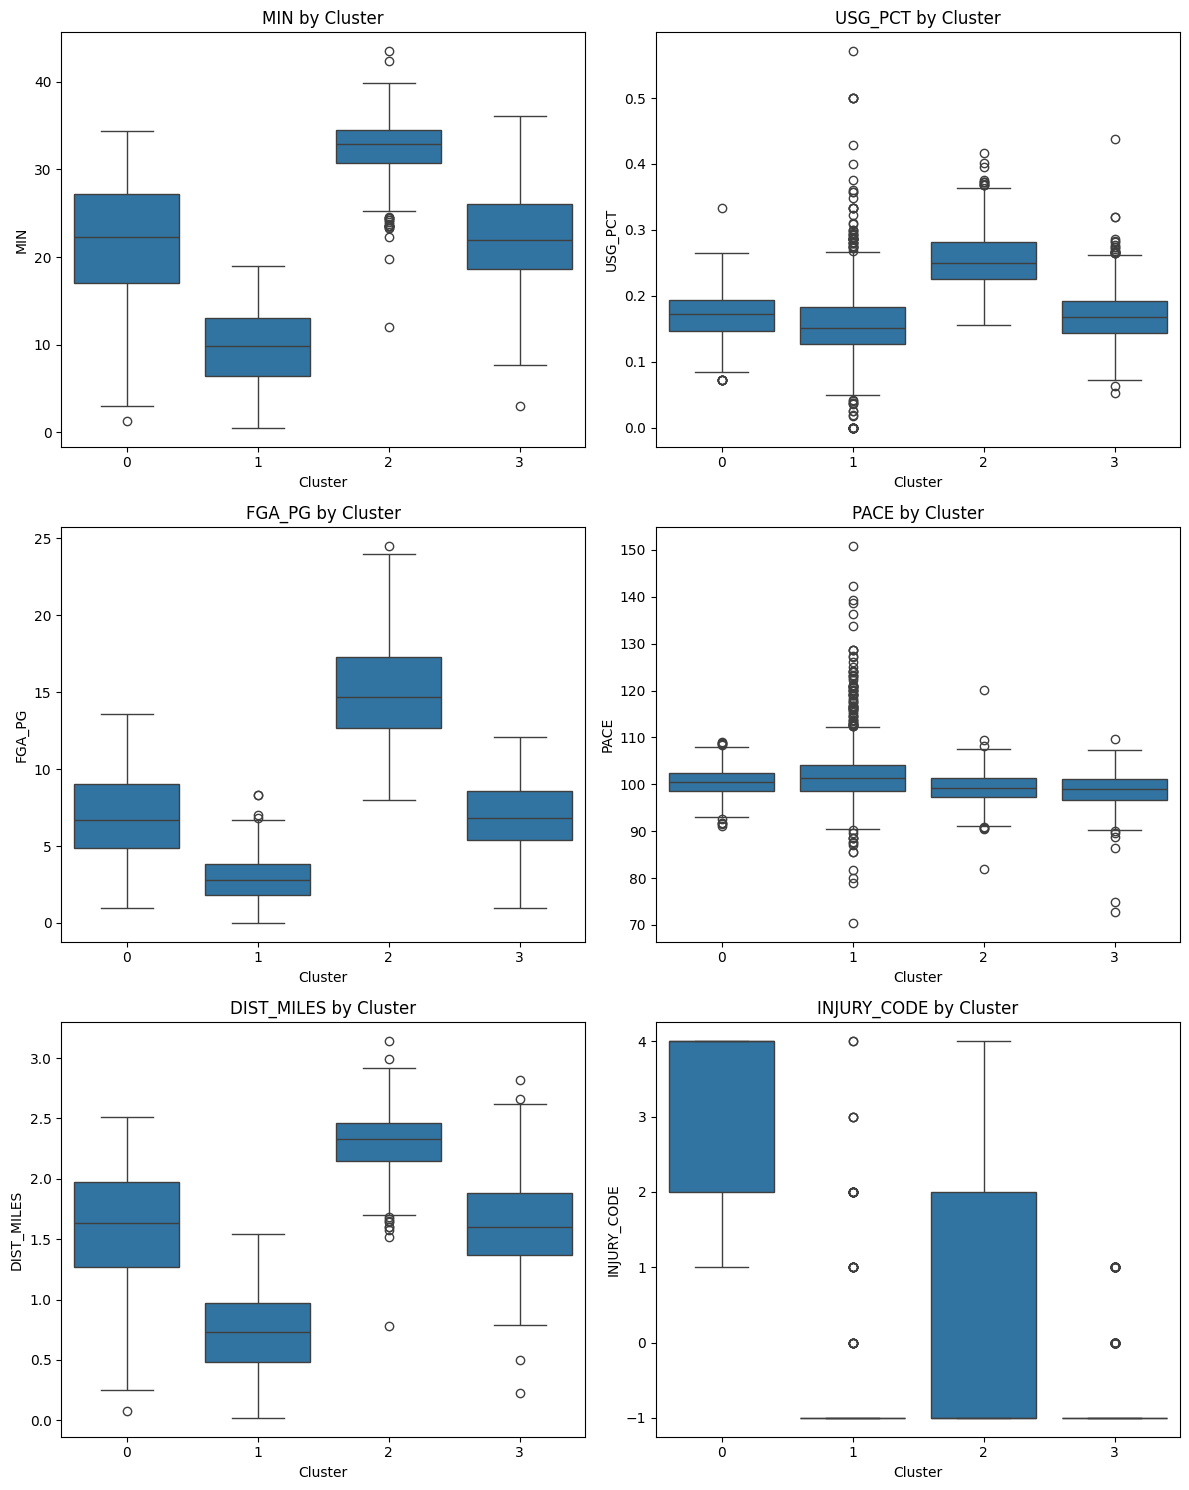

In [22]:
# Set up the grid size
n_features = len(workload_features)
cols = 2  # 2 plots per row
rows = math.ceil(n_features / cols)

# Create subplots
fig, axes = plt.subplots(rows, cols, figsize=(12, 5 * rows))
axes = axes.flatten()  # flatten 2D array for easy indexing

# Plot each feature
for i, feature in enumerate(workload_features):
    sns.boxplot(ax=axes[i], x='Cluster', y=feature, data=db_cleaned)
    axes[i].set_title(f"{feature} by Cluster")
    axes[i].set_xlabel("Cluster")
    axes[i].set_ylabel(feature)

# Hide any unused subplots (in case number of features is odd)
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

# Workload Cluster Analysis

The clustering analysis based on workload metrics (minutes, usage rate, shot attempts, pace, and distance run) revealed four distinct player profiles. Notably, Cluster 2 contains high-usage players who not only cover the most ground but also demonstrate the highest injury code levels, indicating elevated injury risk. In contrast, Cluster 1 includes low-usage players with limited court time and virtually no injury history, though this may reflect limited exposure rather than superior resilience. Cluster 0 and Cluster 3 show balanced profiles with moderate workloads and correspondingly lower injury incidence. These findings reinforce our central hypothesis: intensive play and high physical load are strongly associated with increased injury likelihood in NBA players.

In [9]:
# # Use this before clustering to select a good value for `k`
# evaluate_k_range(segmentation_features, max_k=8)
# evaluate_k_range(injury_features, max_k=8)
# evaluate_k_range(workload_features, max_k=8)

# INJURY CLUSTER 

In [ ]:
db['INJURY_CODE'] = db['INJURED_TYPE'].replace(['None', ' none', 'NONE'], pd.NA)
db['INJURY_CODE'] = db['INJURY_CODE'].astype('category').cat.codes

# 2. Injury Pattern Identification: Based on injury frequency & related stats
injury_features = ['AGE', 'MIN', 'GP', 'DIST_MILES', 'INJURY_CODE']

injury_patterns = run_clustering(injury_features, k=3, title="Injury Pattern Clustering")

In [10]:
# Re-add cluster labels to original dataset
db_cleaned = db[injury_features].copy()
db_cleaned = db_cleaned.replace(['None', ' none', 'NONE'], pd.NA)
for col in db_cleaned.columns:
    db_cleaned[col] = pd.to_numeric(db_cleaned[col], errors='coerce')
db_cleaned = db_cleaned.dropna()
db_cleaned['Cluster'] = injury_patterns['Cluster'].values


In [11]:
# Mean of each feature per cluster
summary = db_cleaned.groupby('Cluster').mean()
print(summary)


               AGE        MIN         GP  DIST_MILES  INJURY_CODE
Cluster                                                          
0        27.267710  25.560078  64.014481    1.840290    -0.913112
1        25.575147  10.392485  24.785363    0.771984    -0.872790
2        26.615619  26.022008  58.241379    1.886471     3.221095


In [13]:
print(db_cleaned['Cluster'].value_counts())

Cluster
0    2555
1    2036
2     986
Name: count, dtype: int64


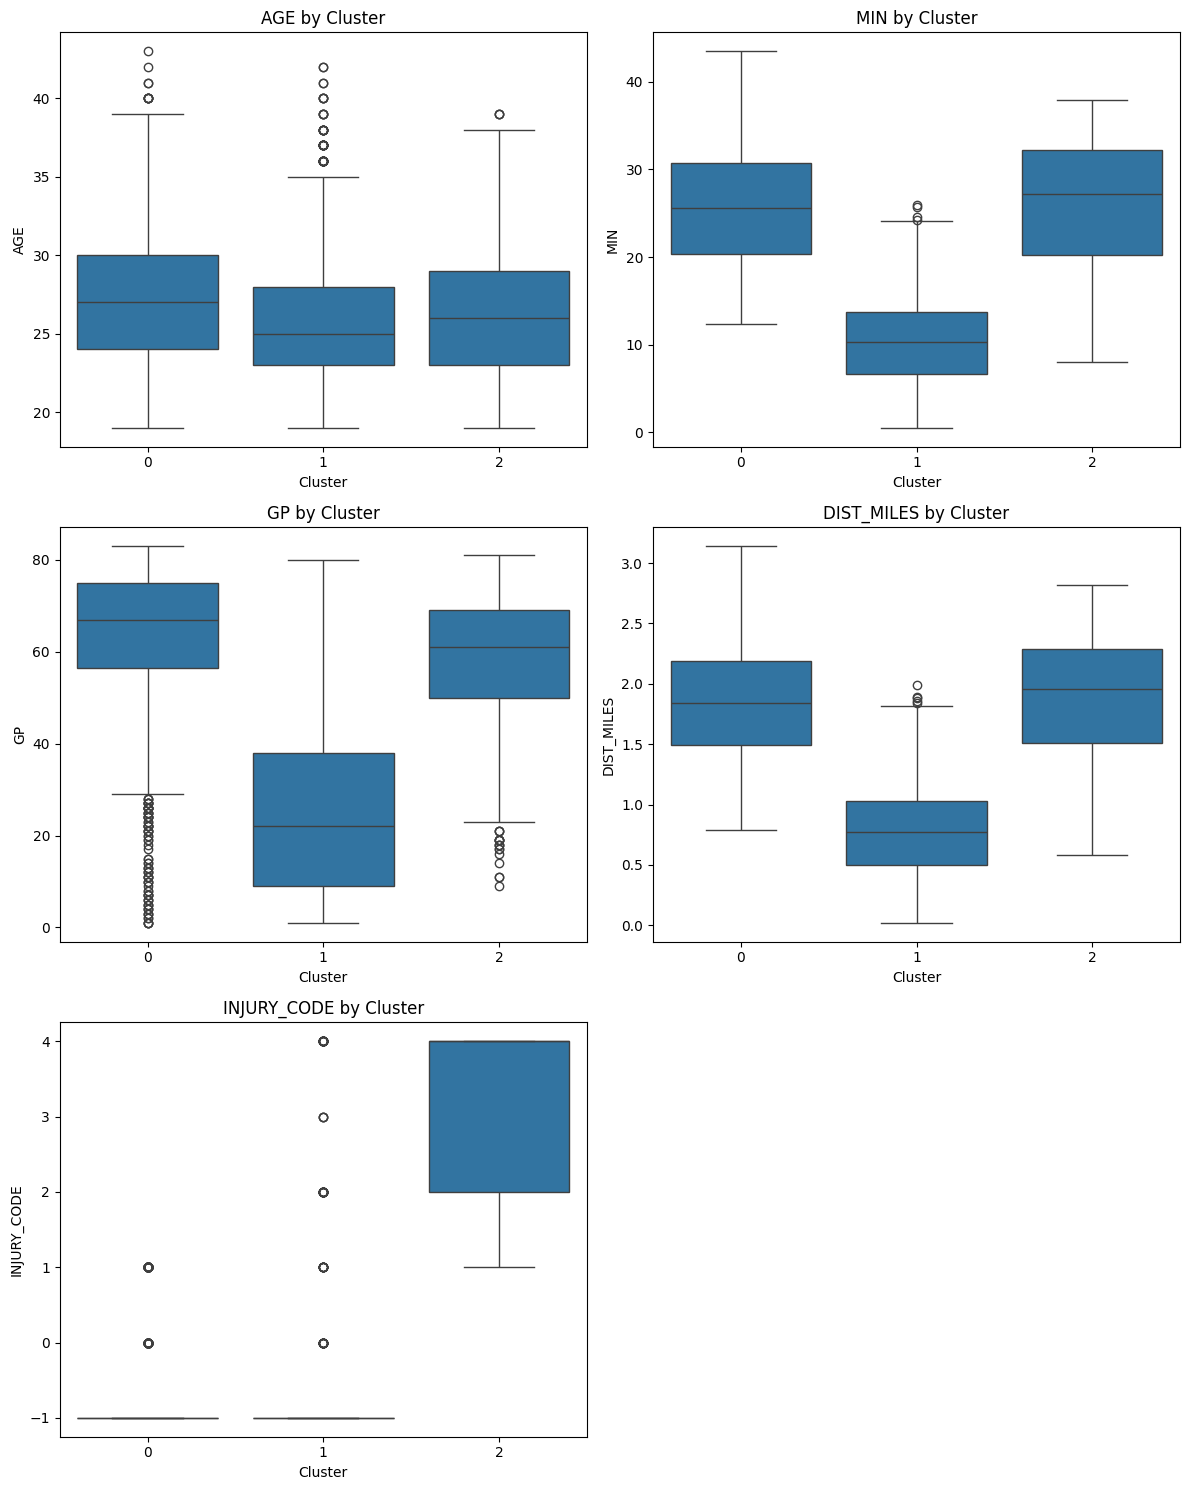

In [ ]:
# Set up the grid size
n_features = len(injury_features)
cols = 2  # 2 plots per row
rows = math.ceil(n_features / cols)

# Create subplots
fig, axes = plt.subplots(rows, cols, figsize=(12, 5 * rows))
axes = axes.flatten()  # flatten 2D array for easy indexing

# Plot each feature
for i, feature in enumerate(injury_features):
    sns.boxplot(ax=axes[i], x='Cluster', y=feature, data=db_cleaned)
    axes[i].set_title(f"{feature} by Cluster")
    axes[i].set_xlabel("Cluster")
    axes[i].set_ylabel(feature)

# Hide any unused subplots (in case number of features is odd)
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

# Injury Cluster Analysis:

To explore patterns in injury susceptibility among NBA players, we applied K-Means clustering to player statistics including age, minutes played, games played, distance run, and injury type. The resulting clusters revealed distinct player profiles with varying injury risk levels.

* **Cluster 0** represents players who are consistently active across many games and play a moderate-to-high number of minutes. Despite their workload, they show a low incidence of reported injuries. These players appear to be physically resilient and are likely well-conditioned starters.
* **Cluster 1** consists largely of players with limited court time — low minutes, few games played, and minimal movement (low distance run). These may include rookies, bench players, or those returning from injury. They exhibit low injury rates, though this may be due to their limited exposure rather than superior resilience.
* **Cluster 2** includes high-workload players who not only play significant minutes and cover more ground but also show markedly higher injury codes. This group likely includes star players or heavy contributors whose intense usage increases their injury risk.

These clusters provide valuable insights into how player workload, age, and activity levels relate to injury outcomes. Specifically, the results support our hypothesis that **players with greater in-game exposure are more prone to injuries**, and that **injury risk is not evenly distributed across the league**. This data-driven segmentation can inform targeted load management strategies or injury prevention programs based on player profiles.
